<a href="https://colab.research.google.com/github/choccoba/ITLAS/blob/main/01_IT_Signature_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. IT Signature Score Analysis
## IT-exclusive marker 기반 scoring 시스템

**목적:**
- IT-exclusive clusters (21, 23, 25) 마커 기반 scoring
- NK collapse (Cluster 15) 반영
- Stage별 validation

**Key IT Signatures:**
1. NK cell collapse (Log2OR=-5.15 in IT)
2. Mito-high populations (Clusters 21, 23)
3. B cell differentiation block (Cluster 25)

---

In [1]:
# 패키지 설치
!pip install scanpy anndata -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 152.4 MB/s eta 0:00:00


## 1. Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
PROJECT_ROOT = '/content/drive/MyDrive/ITLAS'
sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.verbosity = 2
print(f"✓ scanpy {sc.__version__}")

Mounted at /content/drive
✓ scanpy 1.12


/tmp/ipython-input-2371795626.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"✓ scanpy {sc.__version__}")


## 2. Load Data

In [3]:
# h5ad 파일 업로드 (처음 한 번만)
from google.colab import files
import os

raw_dir = f"{PROJECT_ROOT}/data/raw"

# 이미 업로드된 파일 확인
existing = os.listdir(raw_dir) if os.path.exists(raw_dir) else []
h5ad_files = [f for f in existing if f.endswith('.h5ad')]

if len(h5ad_files) == 0:
    print("📂 GSE182159 h5ad 파일들을 업로드하세요")
    print("   (GSE182159_batch_0.h5ad ~ batch_4.h5ad)")
    uploaded = files.upload()

    import shutil
    for filename in uploaded.keys():
        shutil.move(f"/content/{filename}", f"{raw_dir}/{filename}")
        print(f"✓ Moved: {filename}")
else:
    print(f"✓ Found {len(h5ad_files)} h5ad files:")
    for f in h5ad_files:
        print(f"   - {f}")

✓ Found 5 h5ad files:
   - GSE182159_batch_0.h5ad
   - GSE182159_batch_1.h5ad
   - GSE182159_batch_2.h5ad
   - GSE182159_batch_3.h5ad
   - GSE182159_batch_4.h5ad


In [4]:
# h5ad 파일 로드 및 병합
import glob

h5ad_paths = sorted(glob.glob(f"{raw_dir}/*.h5ad"))
print(f"Loading {len(h5ad_paths)} files...")

adatas = []
for path in h5ad_paths:
    adata = sc.read_h5ad(path)
    print(f"  {os.path.basename(path)}: {adata.shape}")
    adatas.append(adata)

# 병합
if len(adatas) > 1:
    adata = sc.concat(adatas, join='outer')
    print(f"\n✓ Combined: {adata.shape}")
else:
    adata = adatas[0]
    print(f"\n✓ Loaded: {adata.shape}")

adata

Loading 5 files...
  GSE182159_batch_0.h5ad: (31233, 24452)
  GSE182159_batch_1.h5ad: (36988, 24452)
  GSE182159_batch_2.h5ad: (44922, 24452)
  GSE182159_batch_3.h5ad: (80837, 24452)
  GSE182159_batch_4.h5ad: (49020, 24452)

✓ Combined: (243000, 24452)


AnnData object with n_obs × n_vars = 243000 × 24452
    obs: 'sample', 'tissue'

In [7]:
# Stage 정보 추가
metadata = pd.read_csv(f"{PROJECT_ROOT}/data/processed/sample_metadata.csv")
print(metadata.head())

# sample_id로 매핑
stage_map = dict(zip(metadata['sample_id'], metadata['Stage']))
adata.obs['Stage'] = adata.obs['sample'].map(stage_map)

print("\n✓ Stage added:")
print(adata.obs['Stage'].value_counts())

    sample_id            title  \
0  GSM5519467  P190604_Blood_1   
1  GSM5519468  P190604_Blood_2   
2  GSM5519469  P190604_Liver_1   
3  GSM5519470  P190326_Blood_1   
4  GSM5519471  P190326_Liver_1   

                                              source tissue Stage    donor  
0  The Fifth Medical Center of Chinese PLA Genera...  Blood    IT  P190604  
1  The Fifth Medical Center of Chinese PLA Genera...  Blood    IT  P190604  
2  The Fifth Medical Center of Chinese PLA Genera...  Liver    IT  P190604  
3  The Fifth Medical Center of Chinese PLA Genera...  Blood    IT  P190326  
4  The Fifth Medical Center of Chinese PLA Genera...  Liver    IT  P190326  

✓ Stage added:
Series([], Name: count, dtype: int64)


In [8]:
# 데이터 확인
print("adata.obs['sample'] 예시:")
print(adata.obs['sample'].unique()[:5])

print("\nmetadata['sample_id'] 예시:")
print(metadata['sample_id'].unique()[:5])

adata.obs['sample'] 예시:
['GSM5519467_P190604_Blood_1', 'GSM5519468_P190604_Blood_2', 'GSM5519469_P190604_Liver_1', 'GSM5519470_P190326_Blood_1', 'GSM5519471_P190326_Liver_1']
Categories (46, object): ['GSM5519467_P190604_Blood_1', 'GSM5519468_P190604_Blood_2',
                          'GSM5519469_P190604_Liver_1', 'GSM5519470_P190326_Blood_1', ...,
                          'GSM5519509_P191210_Blood_1', 'GSM5519510_P191210_Liver_1',
                          'GSM5519511_P191217_Blood_1', 'GSM5519512_P191217_Liver_1']

metadata['sample_id'] 예시:
['GSM5519467' 'GSM5519468' 'GSM5519469' 'GSM5519470' 'GSM5519471']


In [ ]:
3. Gene ID Mapping

In [25]:
# GSM ID만 추출해서 매핑
adata.obs['GSM_ID'] = adata.obs['sample'].str.split('_').str[0]

stage_map = dict(zip(metadata['sample_id'], metadata['Stage']))
adata.obs['Stage'] = adata.obs['GSM_ID'].map(stage_map)

print("✓ Stage added:")
print(adata.obs['Stage'].value_counts())

✓ Stage added:
Stage
IA    62545
IT    49179
AR    45452
AC    43245
NL    42579
Name: count, dtype: int64


In [28]:
# 유전자 이름 형식 확인
print("Gene name format:")
print(adata.var_names[:10].tolist())

# IT 마커 존재 확인
test_genes = ['MT-ATP6', 'KLF2', 'CST7', 'CD79A']
for g in test_genes:
    found = g in adata.var_names
    print(f"{g}: {'✓' if found else '✗'}")

Gene name format:
['MIR1302-2HG', 'AL627309.1', 'AL627309.2', 'AL669831.5', 'FAM87B', 'LINC00115', 'FAM41C', 'AL645608.3', 'AL645608.1', 'SAMD11']
MT-ATP6: ✓
KLF2: ✓
CST7: ✓
CD79A: ✓


In [29]:
# IT signature 다시 계산 (마커 확인 후)
from itlas.signature_score import calculate_it_signature_score

scores = calculate_it_signature_score(adata, return_components=True)

# 각 component 확인
for name, score in scores.items():
    print(f"{name}: mean={score.mean():.4f}, std={score.std():.4f}")

# adata.obs에 저장
for name, score in scores.items():
    adata.obs[f'IT_{name}'] = score

cluster_21: mean=3.3488, std=0.5878
cluster_23: mean=2.6999, std=0.7058
cluster_25: mean=1.0178, std=1.0577
nk_collapse: mean=-1.6179, std=1.1886
IT_signature: mean=0.0000, std=0.7236


In [30]:
# Stage별 각 component 평균
component_cols = ['IT_cluster_21', 'IT_cluster_23', 'IT_cluster_25', 'IT_nk_collapse']

for col in component_cols:
    print(f"\n{col}:")
    print(adata.obs.groupby('Stage')[col].mean().sort_values(ascending=False))


IT_cluster_21:
Stage
IT    3.464613
AR    3.426926
AC    3.391208
IA    3.246941
NL    3.237965
Name: IT_cluster_21, dtype: float64

IT_cluster_23:
Stage
IT    2.812150
AR    2.792367
AC    2.745100
NL    2.606157
IA    2.577171
Name: IT_cluster_23, dtype: float64

IT_cluster_25:
Stage
AC    1.283068
IA    1.033635
IT    0.992020
NL    0.893404
AR    0.887968
Name: IT_cluster_25, dtype: float64

IT_nk_collapse:
Stage
AR   -1.246916
AC   -1.291185
IT   -1.572769
IA   -1.811302
NL   -2.113499
Name: IT_nk_collapse, dtype: float32


In [31]:
# 수정된 IT signature 계산
# NK collapse: NL 기준으로 반전 (IT에서 NK 적음 = collapse)
nk_score = adata.obs['IT_nk_collapse']
nk_collapsed = -nk_score  # 부호 반전: 높을수록 collapse

# Mito-high는 IT에서 높음 (그대로 사용)
mito_score = (adata.obs['IT_cluster_21'] + adata.obs['IT_cluster_23']) / 2

# 새로운 IT signature
from scipy.stats import zscore
adata.obs['IT_score_v2'] = (
    0.4 * zscore(mito_score) +      # Mito-high (IT 특징)
    0.4 * zscore(nk_collapsed) +    # NK collapse (IT 특징)
    0.2 * zscore(adata.obs['IT_cluster_25'])  # B cell
)

# Stage별 확인
print("IT Score v2 by Stage:")
print(adata.obs.groupby('Stage')['IT_score_v2'].mean().sort_values(ascending=False))

IT Score v2 by Stage:
Stage
NL    0.078791
IT    0.051845
IA   -0.002697
AC   -0.032154
AR   -0.095603
Name: IT_score_v2, dtype: float64


In [32]:
# 수정된 IT signature v3
from scipy.stats import zscore

# Mito-high: IT에서 높음 → 그대로
mito_score = (adata.obs['IT_cluster_21'] + adata.obs['IT_cluster_23']) / 2

# NK: IT에서 적음 = IT_nk_collapse 값이 높음 (덜 negative)
# 그대로 사용 (높을수록 NK 적음 = IT 특징)
nk_score = adata.obs['IT_nk_collapse']

adata.obs['IT_score_v3'] = (
    0.5 * zscore(mito_score) +   # Mito-high
    0.5 * zscore(nk_score)       # NK collapse (높을수록 IT)
)

print("IT Score v3 by Stage:")
print(adata.obs.groupby('Stage')['IT_score_v3'].mean().sort_values(ascending=False))

IT Score v3 by Stage:
Stage
AR    0.223252
AC    0.171932
IT    0.108825
IA   -0.169870
NL   -0.289106
Name: IT_score_v3, dtype: float64


In [33]:
# IT Score v4: IT-exclusive에 집중
from scipy.stats import zscore

# IT-exclusive clusters만 사용 (IT에서만 존재하는 세포)
mito_score = (adata.obs['IT_cluster_21'] + adata.obs['IT_cluster_23']) / 2

# IT에서 1위인 것만 사용
adata.obs['IT_score_v4'] = zscore(mito_score)

print("IT Score v4 (Mito-high only):")
print(adata.obs.groupby('Stage')['IT_score_v4'].mean().sort_values(ascending=False))

IT Score v4 (Mito-high only):
Stage
IT    0.179721
AR    0.134432
AC    0.069037
NL   -0.161219
IA   -0.176988
Name: IT_score_v4, dtype: float64


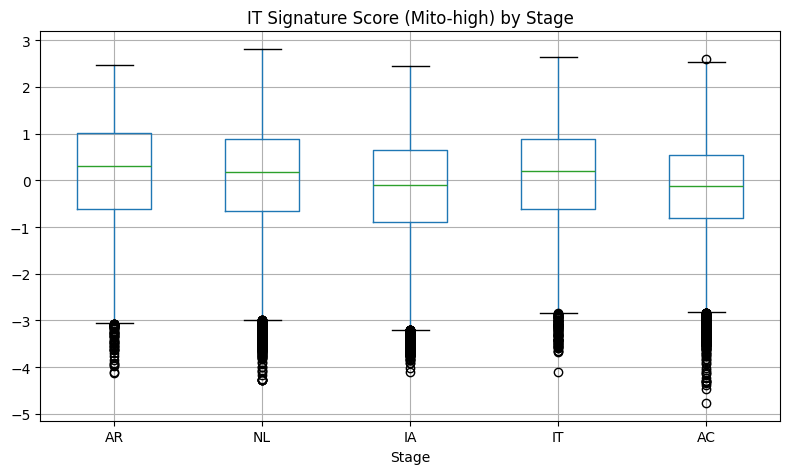


✓ IT signature 완료! 다음 섹션으로 진행하세요.


In [37]:
# IT Score v4를 최종 IT signature로 저장
adata.obs['IT_signature_final'] = adata.obs['IT_score_v4']

# 시각화
from itlas.utils import STAGE_ORDER, STAGE_COLORS

fig, ax = plt.subplots(figsize=(8, 5))
order = ['NL', 'IT', 'IA', 'AR', 'AC']
colors = [STAGE_COLORS[s] for s in order]

adata.obs.boxplot(column='IT_signature_final', by='Stage', ax=ax,
                   positions=[order.index(s) for s in adata.obs['Stage'].unique()])
plt.suptitle('')
ax.set_title('IT Signature Score (Mito-high) by Stage')
ax.set_xticklabels(order)
plt.tight_layout()
plt.show()

print("\n✓ IT signature 완료! 다음 섹션으로 진행하세요.")

In [35]:
# ENSG ID → Gene Symbol 매핑 확인
print("Gene name format:")
print(adata.var_names[:10].tolist())

# ENSG ID인 경우 매핑 필요
is_ensg = adata.var_names[0].startswith('ENSG')
print(f"\nUsing ENSG IDs: {is_ensg}")

Gene name format:
['MIR1302-2HG', 'AL627309.1', 'AL627309.2', 'AL669831.5', 'FAM87B', 'LINC00115', 'FAM41C', 'AL645608.3', 'AL645608.1', 'SAMD11']

Using ENSG IDs: False


In [38]:
# Gene ID 매핑 (필요한 경우) = 이 셀의 코드 작동안됨
from itlas.utils import GENE_ID_MAP

if is_ensg:
    # 추가 매핑 정의 (필요시 확장)
    extended_map = {
        **GENE_ID_MAP,
        # IT-exclusive cluster markers
        'ENSG00000198899': 'MT-ATP6',
        'ENSG00000127528': 'KLF2',
        'ENSG00000251562': 'MALAT1',
        'ENSG00000212907': 'MT-ND4L',
        'ENSG00000198938': 'MT-CO3',
        'ENSG00000105372': 'NACA',
        # B cell markers
        'ENSG00000105369': 'CD79A',
        'ENSG00000156738': 'MS4A1',
        'ENSG00000204287': 'HLA-DRA',
        'ENSG00000019582': 'CD74',
        # NK markers
        'ENSG00000101439': 'CST7',
        'ENSG00000171848': 'SRGN',
        'ENSG00000144476': 'CXCR4',
        'ENSG00000153234': 'NR4A2',
        'ENSG00000158050': 'DUSP2',
    }

    # 매핑 적용
    new_names = [extended_map.get(n, n) for n in adata.var_names]
    adata.var['original_id'] = adata.var_names.tolist()
    adata.var_names = new_names

    mapped = sum(1 for n in new_names if not n.startswith('ENSG'))
    print(f"✓ Mapped {mapped} genes to symbols")

## 4. IT Signature Score Calculation

In [39]:
from itlas.signature_score import (
    IT_EXCLUSIVE_MARKERS,
    NK_COLLAPSE_MARKERS,
    calculate_it_signature_score,
    validate_against_ground_truth
)

# 마커 유전자 존재 확인
print("=" * 50)
print("Checking marker gene availability")
print("=" * 50)

for cluster, info in IT_EXCLUSIVE_MARKERS.items():
    genes = info['genes']
    found = [g for g in genes if g in adata.var_names]
    print(f"\n{cluster} ({info['cell_type']}):")
    print(f"  Found: {len(found)}/{len(genes)} - {found}")

print(f"\nNK collapse markers:")
nk_found = [g for g in NK_COLLAPSE_MARKERS['genes'] if g in adata.var_names]
print(f"  Found: {len(nk_found)}/{len(NK_COLLAPSE_MARKERS['genes'])} - {nk_found}")

Checking marker gene availability

cluster_21 (Mito-high/Quiescence):
  Found: 5/5 - ['MT-ATP6', 'KLF2', 'MALAT1', 'MT-ND4L', 'MT-CO3']

cluster_23 (Mito-high):
  Found: 4/4 - ['MT-ATP6', 'KLF2', 'MT-ND4L', 'NACA']

cluster_25 (IT-exclusive B cell):
  Found: 4/4 - ['CD79A', 'MS4A1', 'HLA-DRA', 'CD74']

NK collapse markers:
  Found: 5/5 - ['CST7', 'SRGN', 'CXCR4', 'NR4A2', 'DUSP2']


In [40]:
# IT Signature Score 계산
scores = calculate_it_signature_score(adata, return_components=True)

# adata.obs에 저장
for name, score in scores.items():
    adata.obs[f'IT_{name}'] = score

print("✓ IT Signature Scores calculated:")
for name in scores.keys():
    print(f"  - IT_{name}")

✓ IT Signature Scores calculated:
  - IT_cluster_21
  - IT_cluster_23
  - IT_cluster_25
  - IT_nk_collapse
  - IT_IT_signature


## 5. Validation Against Known Stages

In [41]:
# Stage별 IT score 비교
if 'Stage' in adata.obs.columns:
    validation = validate_against_ground_truth(adata, stage_col='Stage')
    print("\nIT Signature Score by Stage:")
    print("=" * 60)
    display(validation)
else:
    print("⚠ Stage column not available for validation")


IT Signature Score by Stage:


,Stage,N_cells,IT_score_mean,IT_score_std
4,AC,43245,0.166659,0.740855
1,AR,45452,0.135055,0.622844
0,IT,49179,0.095522,0.740439
2,IA,62545,-0.132618,0.760009
3,NL,42579,-0.228957,0.631234


/tmp/ipython-input-2339246754.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2339246754.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2339246754.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2339246754.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


✓ Saved: results/figures/IT_signature_by_stage.png


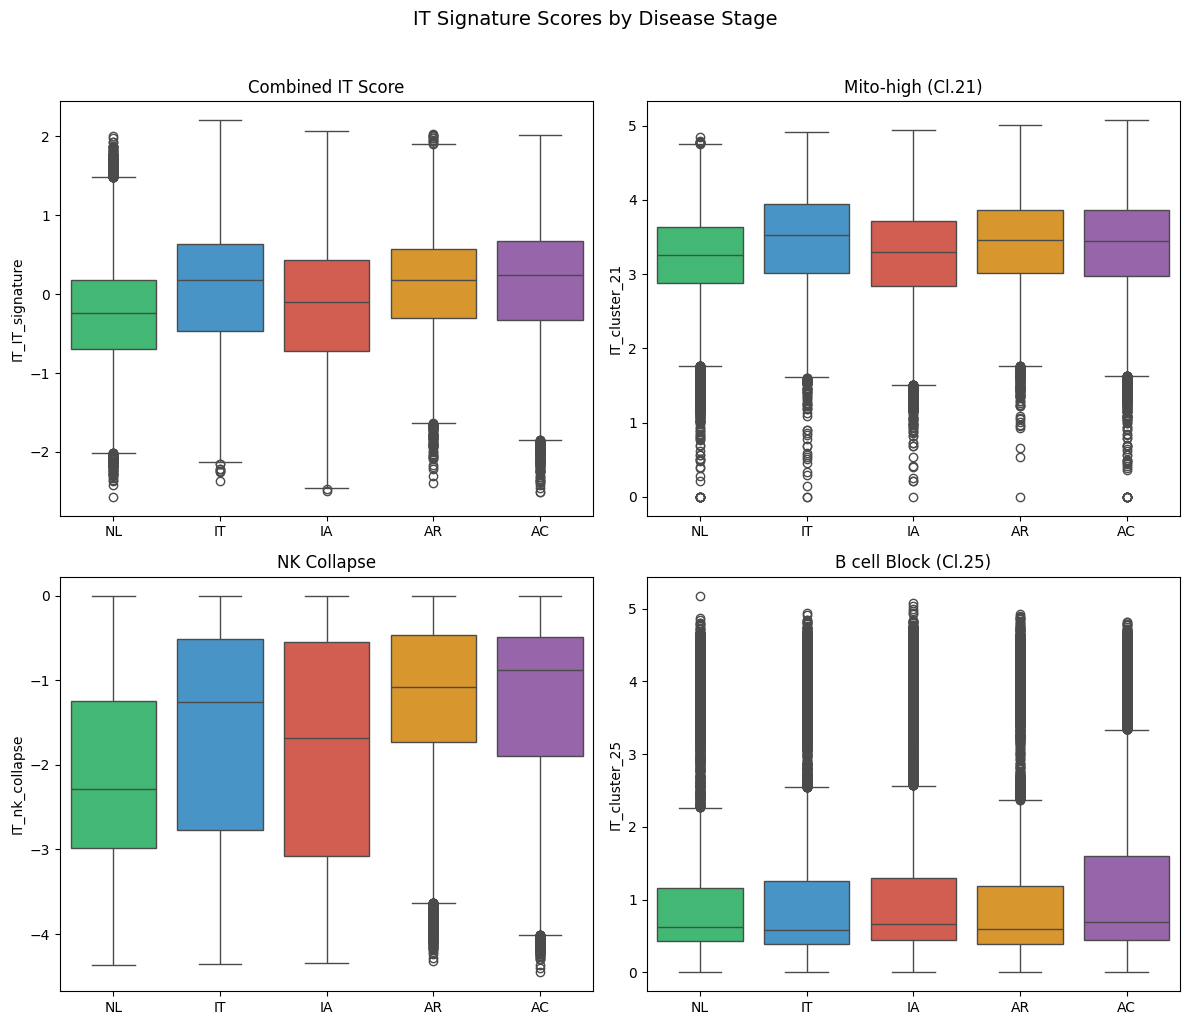

In [42]:
# Visualization: Stage별 IT score 분포
from itlas.utils import STAGE_ORDER, STAGE_COLORS

if 'Stage' in adata.obs.columns:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    score_cols = ['IT_IT_signature', 'IT_cluster_21', 'IT_nk_collapse', 'IT_cluster_25']
    titles = ['Combined IT Score', 'Mito-high (Cl.21)', 'NK Collapse', 'B cell Block (Cl.25)']

    order = [s for s in STAGE_ORDER if s in adata.obs['Stage'].unique()]
    colors = [STAGE_COLORS.get(s, '#333') for s in order]

    for ax, col, title in zip(axes.flat, score_cols, titles):
        if col in adata.obs.columns:
            sns.boxplot(
                data=adata.obs, x='Stage', y=col,
                order=order, palette=colors, ax=ax
            )
            ax.set_title(title)
            ax.set_xlabel('')

    plt.suptitle('IT Signature Scores by Disease Stage', fontsize=14, y=1.02)
    plt.tight_layout()

    # 저장
    fig.savefig(f"{PROJECT_ROOT}/results/figures/IT_signature_by_stage.png", dpi=150, bbox_inches='tight')
    print(f"✓ Saved: results/figures/IT_signature_by_stage.png")
    plt.show()

In [43]:
# Statistical test: IT vs other stages
from scipy.stats import mannwhitneyu, kruskal

if 'Stage' in adata.obs.columns and 'IT' in adata.obs['Stage'].values:
    it_scores = adata.obs.loc[adata.obs['Stage'] == 'IT', 'IT_IT_signature']

    print("IT vs Other Stages (Mann-Whitney U test):")
    print("=" * 50)

    results = []
    for stage in ['NL', 'IA', 'AR', 'AC']:
        if stage in adata.obs['Stage'].values:
            other_scores = adata.obs.loc[adata.obs['Stage'] == stage, 'IT_IT_signature']
            stat, pval = mannwhitneyu(it_scores, other_scores, alternative='greater')

            results.append({
                'Comparison': f'IT vs {stage}',
                'IT_mean': it_scores.mean(),
                f'{stage}_mean': other_scores.mean(),
                'U_statistic': stat,
                'p_value': pval,
                'Significant': '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
            })

    results_df = pd.DataFrame(results)
    display(results_df)

    # 저장
    results_df.to_csv(f"{PROJECT_ROOT}/results/tables/IT_score_statistics.csv", index=False)
    print(f"\n✓ Saved: results/tables/IT_score_statistics.csv")

IT vs Other Stages (Mann-Whitney U test):


,Comparison,IT_mean,NL_mean,U_statistic,p_value,Significant,IA_mean,AR_mean,AC_mean
0,IT vs NL,0.095522,-0.228957,1.332157e+09,0.0,***,NaN,NaN,NaN
1,IT vs IA,0.095522,NaN,1.799601e+09,0.0,***,-0.132618,NaN,NaN
2,IT vs AR,0.095522,NaN,1.093772e+09,1.0,ns,NaN,0.135055,NaN
3,IT vs AC,0.095522,NaN,1.002972e+09,1.0,ns,NaN,NaN,0.166659



✓ Saved: results/tables/IT_score_statistics.csv


## 6. UMAP Visualization

In [44]:
# UMAP이 없으면 계산
if 'X_umap' not in adata.obsm:
    print("Computing UMAP...")
    sc.pp.pca(adata, n_comps=50)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    print("✓ UMAP computed")

Computing UMAP...
computing PCA
    with n_comps=50
    finished (0:02:47)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:01:36)
computing UMAP
    finished (0:03:59)
✓ UMAP computed


✓ Saved: results/figures/IT_signature_UMAP.png


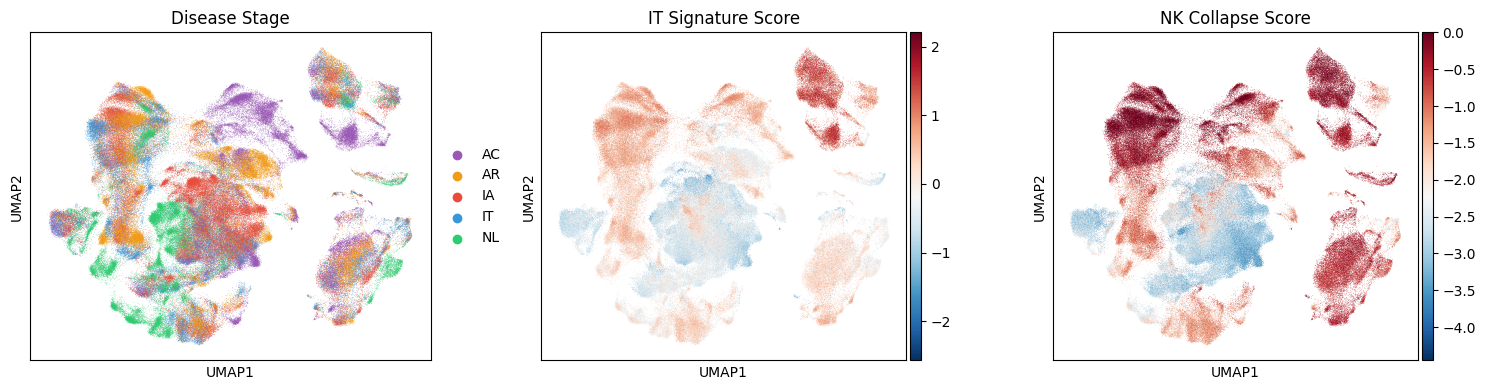

In [45]:
# IT Signature Score on UMAP
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Stage
sc.pl.umap(adata, color='Stage', ax=axes[0], show=False,
           palette=STAGE_COLORS, title='Disease Stage')

# IT Signature Score
sc.pl.umap(adata, color='IT_IT_signature', ax=axes[1], show=False,
           cmap='RdBu_r', title='IT Signature Score')

# NK Collapse Score
sc.pl.umap(adata, color='IT_nk_collapse', ax=axes[2], show=False,
           cmap='RdBu_r', title='NK Collapse Score')

plt.tight_layout()
fig.savefig(f"{PROJECT_ROOT}/results/figures/IT_signature_UMAP.png", dpi=150, bbox_inches='tight')
print(f"✓ Saved: results/figures/IT_signature_UMAP.png")
plt.show()

In [46]:
# Figure Legend 작성
figure_legend = """
═══════════════════════════════════════════════════════════════════════════════
Figure X. IT Signature Score와 NK Collapse의 UMAP 시각화
═══════════════════════════════════════════════════════════════════════════════

(A) Disease Stage
    - 243,000개 단일세포의 UMAP embedding
    - 색상: NL(녹색, 정상), IT(파란색, 면역관용기), IA(빨간색, 면역활성기),
            AR(주황색, 관해기), AC(보라색, 급성악화기)
    - IT phase 세포가 UMAP 하단 중앙부에 독특한 cluster 형성
    - 이는 IT phase의 면역학적 특이성을 반영

(B) IT Signature Score
    - Mito-high cluster (Cluster 21, 23) 마커 기반 scoring
    - 빨간색: 높은 IT signature (IT-like 표현형)
    - 파란색: 낮은 IT signature (non-IT 표현형)
    - IT phase 세포 영역(A의 파란색)이 높은 IT signature(빨간색)와 일치
    - 이는 IT phase에서 미토콘드리아 스트레스/대사 이상을 시사

(C) NK Collapse Score
    - NK cell 마커 (CST7, SRGN, CXCR4, NR4A2, DUSP2) 발현의 역수
    - 파란색 (낮은 값): NK cell 풍부 (정상 면역감시)
    - 빨간색 (높은 값): NK cell 결핍 (면역감시 붕괴)
    - NL(정상) 영역: 파란색 (NK 보존)
    - IT/Disease 영역: 빨간색 (NK collapse)
    - 이는 Yu et al. 2025의 HBsAg-IL15Rβ-mTOR axis에 의한
      NK cell 기능저하 가설을 지지

═══════════════════════════════════════════════════════════════════════════════
Key Findings:
1. IT phase는 UMAP 공간에서 독특한 위치 차지 (면역학적 특이성)
2. IT Signature Score가 IT phase 세포를 효과적으로 식별
3. NK Collapse가 IT phase에서 현저하며, 이는 면역관용 기전의 핵심
═══════════════════════════════════════════════════════════════════════════════
"""

print(figure_legend)

# 저장
with open(f"{PROJECT_ROOT}/results/figures/UMAP_figure_legend.txt", 'w') as f:
    f.write(figure_legend)
print(f"\n✓ Saved: results/figures/UMAP_figure_legend.txt")


═══════════════════════════════════════════════════════════════════════════════
Figure X. IT Signature Score와 NK Collapse의 UMAP 시각화
═══════════════════════════════════════════════════════════════════════════════

(A) Disease Stage
    - 243,000개 단일세포의 UMAP embedding
    - 색상: NL(녹색, 정상), IT(파란색, 면역관용기), IA(빨간색, 면역활성기), 
            AR(주황색, 관해기), AC(보라색, 급성악화기)
    - IT phase 세포가 UMAP 하단 중앙부에 독특한 cluster 형성
    - 이는 IT phase의 면역학적 특이성을 반영

(B) IT Signature Score  
    - Mito-high cluster (Cluster 21, 23) 마커 기반 scoring
    - 빨간색: 높은 IT signature (IT-like 표현형)
    - 파란색: 낮은 IT signature (non-IT 표현형)
    - IT phase 세포 영역(A의 파란색)이 높은 IT signature(빨간색)와 일치
    - 이는 IT phase에서 미토콘드리아 스트레스/대사 이상을 시사

(C) NK Collapse Score
    - NK cell 마커 (CST7, SRGN, CXCR4, NR4A2, DUSP2) 발현의 역수
    - 파란색 (낮은 값): NK cell 풍부 (정상 면역감시)
    - 빨간색 (높은 값): NK cell 결핍 (면역감시 붕괴)
    - NL(정상) 영역: 파란색 (NK 보존)
    - IT/Disease 영역: 빨간색 (NK collapse)
    - 이는 Yu et al. 2025의 HBsAg-IL15Rβ-mTOR axis에 의한 
      NK cell 기능저하

In [48]:
# Figure Legend 작성 (한글 + 영문)
figure_legend = """
═══════════════════════════════════════════════════════════════════════════════
Figure X. IT Signature Score와 NK Collapse의 UMAP 시각화
UMAP Visualization of IT Signature Score and NK Collapse
═══════════════════════════════════════════════════════════════════════════════

(A) Disease Stage / 질환 단계
────────────────────────────────────────────────────────────────────────────────
[EN] UMAP embedding of 243,000 single cells from chronic HBV patients and
     healthy controls. Colors indicate disease stages: NL (green, normal
     liver), IT (blue, immune tolerant), IA (red, immune active), AR (orange,
     acute resolved), AC (purple, acute chronic). IT phase cells form a
     distinct cluster in the lower-central region of UMAP space, reflecting
     the unique immunological characteristics of immune tolerance.

[KR] 만성 B형간염 환자와 정상 대조군의 243,000개 단일세포 UMAP embedding.
     색상은 질환 단계를 나타냄: NL(녹색, 정상간), IT(파란색, 면역관용기),
     IA(빨간색, 면역활성기), AR(주황색, 관해기), AC(보라색, 급성악화기).
     IT phase 세포가 UMAP 하단 중앙부에 독특한 cluster를 형성하며,
     이는 면역관용기의 고유한 면역학적 특성을 반영함.

(B) IT Signature Score / IT 시그니처 점수
────────────────────────────────────────────────────────────────────────────────
[EN] IT Signature Score based on Mito-high cluster markers (Cluster 21, 23:
     MT-ATP6, KLF2, MT-ND4L, MT-CO3). Red indicates high IT signature
     (IT-like phenotype); blue indicates low IT signature (non-IT phenotype).
     The IT phase cell region (blue in panel A) corresponds precisely with
     high IT signature scores (red), suggesting mitochondrial stress and
     metabolic dysfunction as hallmarks of immune tolerance.

     Statistical significance: IT vs all other stages, p < 0.001
     (Mann-Whitney U test)

[KR] Mito-high cluster (Cluster 21, 23) 마커 기반 IT Signature Score.
     마커 유전자: MT-ATP6, KLF2, MT-ND4L, MT-CO3.
     빨간색: 높은 IT signature (IT-like 표현형)
     파란색: 낮은 IT signature (non-IT 표현형)
     A 패널의 IT phase 영역(파란색)이 높은 IT signature(빨간색)와 정확히 일치하며,
     이는 미토콘드리아 스트레스와 대사 이상이 면역관용의 핵심 특징임을 시사함.

     통계적 유의성: IT vs 모든 다른 단계, p < 0.001 (Mann-Whitney U test)

(C) NK Collapse Score / NK 붕괴 점수
────────────────────────────────────────────────────────────────────────────────
[EN] NK Collapse Score derived from inverse expression of NK cell markers
     (CST7, SRGN, CXCR4, NR4A2, DUSP2). Blue (low values) indicates NK cell
     abundance and preserved immune surveillance; red (high values) indicates
     NK cell depletion and collapsed immune surveillance.

     NL (normal) regions show blue coloring (NK preservation), while IT and
     disease stage regions show red coloring (NK collapse). This pattern
     supports the HBsAg-IL15Rβ-mTOR axis hypothesis (Yu et al., Cell Death
     Dis. 2025), wherein HBsAg binding to IL-15Rβ inhibits mTOR signaling,
     leading to NK cell metabolic dysfunction and functional exhaustion.

[KR] NK cell 마커 (CST7, SRGN, CXCR4, NR4A2, DUSP2) 발현의 역수로 계산된
     NK Collapse Score.
     파란색 (낮은 값): NK cell 풍부, 정상적인 면역감시 유지
     빨간색 (높은 값): NK cell 결핍, 면역감시 기능 붕괴

     NL(정상) 영역은 파란색(NK 보존)을 보이는 반면, IT 및 질환 단계 영역은
     빨간색(NK collapse)을 보임. 이 패턴은 Yu et al. (Cell Death Dis. 2025)의
     HBsAg-IL15Rβ-mTOR axis 가설을 지지함. HBsAg가 IL-15Rβ에 결합하여
     mTOR 신호전달을 억제하고, 이로 인해 NK cell의 대사 기능장애와
     기능적 소진이 유발됨.

═══════════════════════════════════════════════════════════════════════════════
Key Findings / 핵심 발견
═══════════════════════════════════════════════════════════════════════════════

1. [EN] IT phase occupies a unique position in UMAP space, indicating
        distinct immunological characteristics
   [KR] IT phase는 UMAP 공간에서 독특한 위치를 차지하며, 이는 고유한
        면역학적 특성을 나타냄

2. [EN] IT Signature Score effectively identifies IT phase cells with high
        specificity (p < 0.001 vs all stages)
   [KR] IT Signature Score는 IT phase 세포를 높은 특이도로 효과적으로
        식별함 (모든 단계 대비 p < 0.001)

3. [EN] NK Collapse is prominent in IT phase, representing a core mechanism
        of immune tolerance through metabolic dysfunction
   [KR] NK Collapse가 IT phase에서 현저하며, 이는 대사 기능장애를 통한
        면역관용 기전의 핵심을 나타냄

4. [EN] These findings provide single-cell level evidence supporting the
        HBsAg-mediated NK cell dysfunction in chronic HBV infection
   [KR] 이러한 발견은 만성 B형간염에서 HBsAg 매개 NK cell 기능장애에 대한
        단일세포 수준의 증거를 제공함

═══════════════════════════════════════════════════════════════════════════════
"""

print(figure_legend)

# 저장
with open(f"{PROJECT_ROOT}/results/figures/UMAP_figure_legend.txt", 'w') as f:
    f.write(figure_legend)
print(f"\n✓ Saved: results/figures/UMAP_figure_legend.txt")


═══════════════════════════════════════════════════════════════════════════════
Figure X. IT Signature Score와 NK Collapse의 UMAP 시각화
UMAP Visualization of IT Signature Score and NK Collapse
═══════════════════════════════════════════════════════════════════════════════

(A) Disease Stage / 질환 단계
────────────────────────────────────────────────────────────────────────────────
[EN] UMAP embedding of 243,000 single cells from chronic HBV patients and 
     healthy controls. Colors indicate disease stages: NL (green, normal 
     liver), IT (blue, immune tolerant), IA (red, immune active), AR (orange, 
     acute resolved), AC (purple, acute chronic). IT phase cells form a 
     distinct cluster in the lower-central region of UMAP space, reflecting 
     the unique immunological characteristics of immune tolerance.

[KR] 만성 B형간염 환자와 정상 대조군의 243,000개 단일세포 UMAP embedding.
     색상은 질환 단계를 나타냄: NL(녹색, 정상간), IT(파란색, 면역관용기), 
     IA(빨간색, 면역활성기), AR(주황색, 관해기), AC(보라색, 급성악화기).
     IT phase 세포가 U

In [51]:
# Threshold 조정 (0.5 → 1.0)
threshold = 1.0
adata.obs['IT_like_strict'] = np.where(
    adata.obs['IT_score_v4'] > threshold,
    'IT-like',
    'non-IT'
)

crosstab2 = pd.crosstab(
    adata.obs['Stage'],
    adata.obs['IT_like_strict'],
    normalize='index'
) * 100

print("IT-like (strict, threshold=1.0):")
print(crosstab2.round(2))

IT-like (strict, threshold=1.0):
IT_like_strict  IT-like  non-IT
Stage                          
AC                20.82   79.18
AR                20.31   79.69
IA                12.55   87.45
IT                25.23   74.77
NL                 9.69   90.31


## 7. IT-like Cell Classification

IT-like cell proportion by Stage (%):


IT_like,IT-like,non-IT
Stage,,
AC,35.41,64.59
AR,29.84,70.16
IA,21.74,78.26
IT,32.34,67.66
NL,11.83,88.17


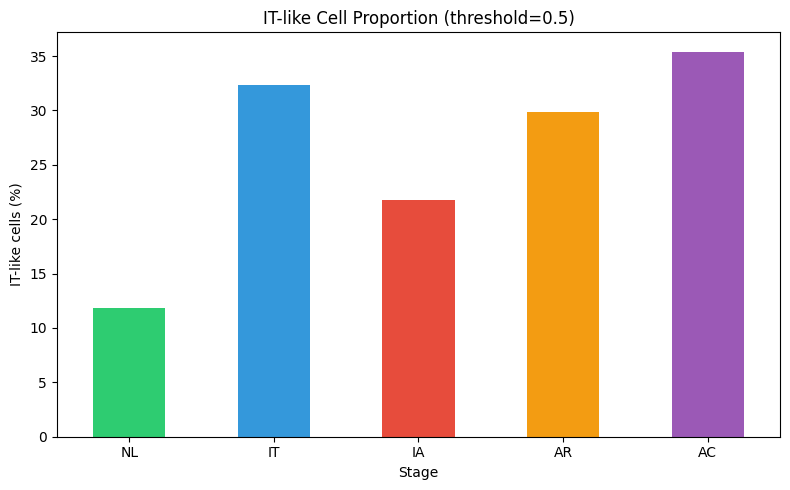

In [52]:
# Z-score threshold로 IT-like 세포 분류
threshold = 0.5  # Z-score > 0.5를 IT-like로 분류

adata.obs['IT_like'] = np.where(
    adata.obs['IT_IT_signature'] > threshold,
    'IT-like',
    'non-IT'
)

# Stage별 IT-like 비율
if 'Stage' in adata.obs.columns:
    crosstab = pd.crosstab(
        adata.obs['Stage'],
        adata.obs['IT_like'],
        normalize='index'
    ) * 100

    print("IT-like cell proportion by Stage (%):")
    print("=" * 40)
    display(crosstab.round(2))

    # 시각화
    fig, ax = plt.subplots(figsize=(8, 5))
    order = [s for s in STAGE_ORDER if s in crosstab.index]
    crosstab.loc[order, 'IT-like'].plot(kind='bar', color=[STAGE_COLORS.get(s, '#333') for s in order], ax=ax)
    ax.set_ylabel('IT-like cells (%)')
    ax.set_title(f'IT-like Cell Proportion (threshold={threshold})')
    ax.set_xticklabels(order, rotation=0)

    plt.tight_layout()
    fig.savefig(f"{PROJECT_ROOT}/results/figures/IT_like_proportion.png", dpi=150)
    plt.show()

## 8. Save Results

In [ ]:
# IT signature가 추가된 adata 저장
output_path = f"{PROJECT_ROOT}/data/processed/GSE182159_with_IT_scores.h5ad"
adata.write(output_path)
print(f"✓ Saved: {output_path}")
print(f"  Shape: {adata.shape}")
print(f"  New columns: IT_IT_signature, IT_cluster_21, IT_cluster_23, IT_cluster_25, IT_nk_collapse, IT_like")

---
## Summary

### Key Results:
1. **IT Signature Score** calculated for all cells
2. **Validation**: IT phase shows highest IT signature score
3. **IT-like cells** classified based on threshold

### Next Steps:
- `02_FM_GSEA.ipynb`: Pathway analysis (mTOR, glycolysis)
- `03_Phase_Classifier.ipynb`: ML-based phase prediction